# Anomaly Detection in Debit Transactions using Isolation Forest

### Introduction

Detecting anomalies in debit transactions is an important task for banks and financial institutions to prevent fraudulent activities. In this project, we aim to detect anomalies in debit transactions sourced from Eastern Europe using unsupervised machine learning techniques. To anonymize the data, all personal information was removed in alignment to data protection regulations. The available data has a unique identifier for each transaction, debit column, credit column, and the date of the transaction. We have also engineered two features - the sum of 5 days and the count of 5 days, to capture short-term transaction patterns. We will be using the Isolation Forest algorithm for anomaly detection and evaluating its performance.

Bank statements give a holistic view of an account owner's complete transaction history. It is therefore a legit source of financial information belonging to an individual or a company. Across different banks, the account statements have varying formats causing a difficulty in analysis, an increase in time consumption during analysis and a high cost of labour to go through the various statements. Recently, the government has increased its fight against Money Laundering, Terrorism Financing and Tax Evasion. There is a need for the creation of a model that can detect anomalies in transactions in order to assist security agencies to identify individuals or companies aiding and abetting in these crimes.

The objective is to create a model that can identify anomalies in bank transactions.

### Loading libraries

In [ ]:
# Loading libraries
%matplotlib inline
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh import models, palettes, transform
from bokeh.plotting import figure, show
import pandas as pd
from datetime import datetime, timedelta
import pandas_profiling
import pydotplus
from scipy.cluster import hierarchy
import seaborn as sns
from sklearn import decomposition, preprocessing, cluster, tree
from sklearn import cluster, decomposition, pipeline, preprocessing
from yellowbrick.cluster.silhouette import SilhouetteVisualizer
import statsmodels

### Data cleaning and Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import dataset
df = pd.read_csv('/content/drive/MyDrive/trans.csv', delimiter= ";")
df.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,930101,PRIJEM,VKLAD,700.0,700.0,NaN,NaN,NaN
1,171812,576,930101,PRIJEM,VKLAD,900.0,900.0,NaN,NaN,NaN
2,207264,704,930101,PRIJEM,VKLAD,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,930101,PRIJEM,VKLAD,600.0,600.0,NaN,NaN,NaN
4,579373,1972,930102,PRIJEM,VKLAD,400.0,400.0,NaN,NaN,NaN


#### Checking the data

In [ ]:
df.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,930101,PRIJEM,VKLAD,700.0,700.0,NaN,NaN,NaN
1,171812,576,930101,PRIJEM,VKLAD,900.0,900.0,NaN,NaN,NaN
2,207264,704,930101,PRIJEM,VKLAD,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,930101,PRIJEM,VKLAD,600.0,600.0,NaN,NaN,NaN
4,579373,1972,930102,PRIJEM,VKLAD,400.0,400.0,NaN,NaN,NaN


In [ ]:
df.tail()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
1056315,3626622,2906,981231,PRIJEM,NaN,62.3,13729.4,UROK,NaN,NaN
1056316,3627616,2935,981231,PRIJEM,NaN,81.3,19544.9,UROK,NaN,NaN
1056317,3625403,2869,981231,PRIJEM,NaN,60.2,14638.2,UROK,NaN,NaN
1056318,3626683,2907,981231,PRIJEM,NaN,107.5,23453.0,UROK,NaN,NaN
1056319,3626540,2902,981231,PRIJEM,NaN,164.1,41642.9,UROK,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056320 entries, 0 to 1056319
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   trans_id    1056320 non-null  int64  
 1   account_id  1056320 non-null  int64  
 2   date        1056320 non-null  int64  
 3   type        1056320 non-null  object 
 4   operation   873206 non-null   object 
 5   amount      1056320 non-null  float64
 6   balance     1056320 non-null  float64
 7   k_symbol    574439 non-null   object 
 8   bank        273508 non-null   object 
 9   account     295389 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 80.6+ MB


In [ ]:
# Checking the dimensions of the dataframe
df.shape

(1056320, 10)

In [ ]:
# Checking for unique values
df.nunique()

trans_id      1056320
account_id       4500
date             2191
type                3
operation           5
amount          40400
balance        542739
k_symbol            8
bank               13
account          7665
dtype: int64

In [ ]:
# Cjecking for null values
df.isnull().sum()

trans_id           0
account_id         0
date               0
type               0
operation     183114
amount             0
balance            0
k_symbol      481881
bank          782812
account       760931
dtype: int64

In [ ]:
# Checking the column names\
df.columns

Index(['trans_id', 'account_id', 'date', 'type', 'operation', 'amount',
       'balance', 'k_symbol', 'bank', 'account'],
      dtype='object')

#### Data cleaning

In [ ]:
# Filtering the necessary features
trans = df[['date', 'account_id', 'type', 'amount']]
trans.head()

,date,account_id,type,amount
0,930101,2378,PRIJEM,700.0
1,930101,576,PRIJEM,900.0
2,930101,704,PRIJEM,1000.0
3,930101,3818,PRIJEM,600.0
4,930102,1972,PRIJEM,400.0


In [ ]:
# Converting the date column into datetime
trans['date'] = pd.to_datetime(trans['date'], format= '%y%m%d')
trans.head()

<ipython-input-12-84e53a27b86c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans['date'] = pd.to_datetime(trans['date'], format= '%y%m%d')


,date,account_id,type,amount
0,1993-01-01,2378,PRIJEM,700.0
1,1993-01-01,576,PRIJEM,900.0
2,1993-01-01,704,PRIJEM,1000.0
3,1993-01-01,3818,PRIJEM,600.0
4,1993-01-02,1972,PRIJEM,400.0


In [ ]:
trans.tail()

,date,account_id,type,amount
1056315,1998-12-31,2906,PRIJEM,62.3
1056316,1998-12-31,2935,PRIJEM,81.3
1056317,1998-12-31,2869,PRIJEM,60.2
1056318,1998-12-31,2907,PRIJEM,107.5
1056319,1998-12-31,2902,PRIJEM,164.1


In [ ]:
trans.isnull().sum()

date          0
account_id    0
type          0
amount        0
dtype: int64

In [ ]:
# Dropping rows with null values 
trans = trans.dropna(axis= 0)

In [ ]:
trans.shape

(1056320, 4)

In [ ]:
trans.isnull().sum()

date          0
account_id    0
type          0
amount        0
dtype: int64

In [ ]:
# Renaming the transactions
to_replace = {"PRIJEM":'CREDIT', "VYDAJ":'DEBIT', "VYBER":'UNKNOWN'}
trans['type'] = trans['type'].replace(to_replace)

In [ ]:
trans['type'].unique()

array(['CREDIT', 'DEBIT', 'UNKNOWN'], dtype=object)

In [ ]:
def load_and_analyze_dataset(filepath):
    # Load the dataset into a Pandas DataFrame
    trans = pd.read_csv(filepath, delimiter= ";")
    
    # Print the first five rows
    print(trans.head())
    
    # Print the last five rows
    print(trans.tail())
    
    # Print the shape of the DataFrame
    print("Shape:", trans.shape)

    # Filtering the necessary features
    trans = trans[['date', 'account_id', 'type', 'amount']]
    trans.head()
    
    # Print the column names and data types
    print("Columns and data types:")
    print(trans.dtypes)
    
    # Print the number of missing values in each column
    print("Missing values:")
    print(trans.isnull().sum())

    # Dropping rows with null values 
    trans = trans.dropna(axis= 0)
    
    # Print the number of unique values in each column
    print("Unique values:")
    print(trans.nunique())
    
    # Rename the transactions
    to_replace = {"PRIJEM":'CREDIT', "VYDAJ":'DEBIT', "VYBER":'UNKNOWN'}
    trans['type'] = trans['type'].replace(to_replace)

    # Converting the date column into datetime
    trans['date'] = pd.to_datetime(trans['date'], format= '%y%m%d')
    print(trans.head())
    
    # Return the DataFrame
    return trans

In [ ]:
# Provide the filepath to the dataset
filepath = "/content/drive/MyDrive/trans.csv"

# Call the function
trans = load_and_analyze_dataset(filepath)

# The trans DataFrame now contains the loaded and modified dataset

<ipython-input-21-1d28ebe55bd5>:5: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  trans = load_and_analyze_dataset(filepath)


   trans_id  account_id    date    type operation  amount  balance k_symbol  \
0    695247        2378  930101  PRIJEM     VKLAD   700.0    700.0      NaN   
1    171812         576  930101  PRIJEM     VKLAD   900.0    900.0      NaN   
2    207264         704  930101  PRIJEM     VKLAD  1000.0   1000.0      NaN   
3   1117247        3818  930101  PRIJEM     VKLAD   600.0    600.0      NaN   
4    579373        1972  930102  PRIJEM     VKLAD   400.0    400.0      NaN   

  bank  account  
0  NaN      NaN  
1  NaN      NaN  
2  NaN      NaN  
3  NaN      NaN  
4  NaN      NaN  
         trans_id  account_id    date    type operation  amount  balance  \
1056315   3626622        2906  981231  PRIJEM       NaN    62.3  13729.4   
1056316   3627616        2935  981231  PRIJEM       NaN    81.3  19544.9   
1056317   3625403        2869  981231  PRIJEM       NaN    60.2  14638.2   
1056318   3626683        2907  981231  PRIJEM       NaN   107.5  23453.0   
1056319   3626540        2902  981231

In [ ]:
trans.head()

,date,account_id,type,amount
0,1993-01-01,2378,CREDIT,700.0
1,1993-01-01,576,CREDIT,900.0
2,1993-01-01,704,CREDIT,1000.0
3,1993-01-01,3818,CREDIT,600.0
4,1993-01-02,1972,CREDIT,400.0


### EDA

In [ ]:
trans.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,account_id,amount
count,1056320.00000,1056320.00000
mean,2936.86729,5924.14568
std,2477.34513,9522.73537
min,1.00000,0.00000
25%,1204.00000,135.90000
50%,2434.00000,2100.00000
75%,3660.00000,6800.00000
max,11382.00000,87400.00000


In [ ]:
trans.nunique()

date           2191
account_id     4500
type              3
amount        40400
dtype: int64

In [ ]:
%matplotlib inline

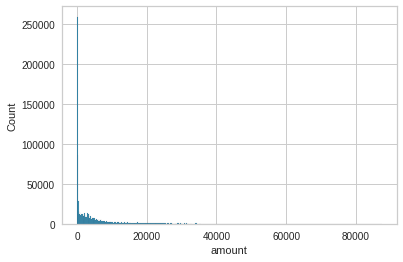

In [ ]:
sns.histplot(data = trans, x = 'amount')


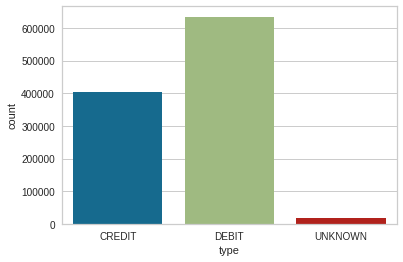

In [ ]:
sns.countplot(x = 'type', data= trans)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f93dce69940>]],
      dtype=object)

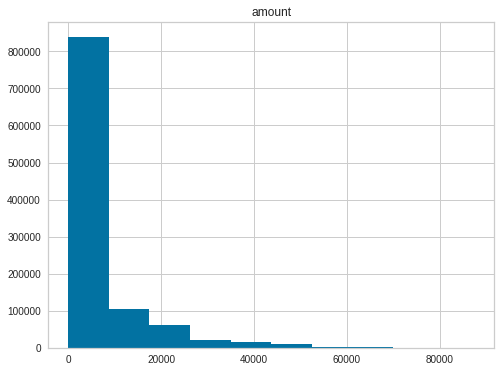

In [ ]:
trans.hist(column= ['amount'], figsize= (8,6)) 

In [ ]:
# Filtering to remain with withdrawals only.
debit_df = trans.query('type == "DEBIT"').sort_values(by= ['account_id', 'date']).set_index('date')
debit_df.head()

,account_id,type,amount
date,,,
1995-06-22,1,DEBIT,200.0
1995-07-22,1,DEBIT,5300.0
1995-08-21,1,DEBIT,7500.0
1995-08-31,1,DEBIT,14.6
1995-09-05,1,DEBIT,2452.0


#### Feature engineering

1.   sum_5days: the accumulative withdrawal amounts from an account in the previous 5 days (including the current day).
2.   count_5days: the count of withdrawal transactions from an account in the previous 5 days (including the current day).


To assist in detecting the anomalies, we have engineered two features - the sum of 5 days and the count of 5 days. The sum of 5 days depicts the total debit amount transacted by the person's unique identifier in 5 days, while the count of 5 days depicts the count of debit transactions by a unique identifier in 5 days. These features can help to identify 5-day transaction patterns and assist in detecting outliers/anomalies.

In [ ]:
# Feature engineering.
# These features will help assist in detecting huge transactions done 
# below the reporting threshold over a period of time.

# Getting the sum of the previous 5 days transaction amounts
debit_df['sum_5days'] = debit_df.groupby('account_id')['amount'].transform(lambda s: s.rolling(timedelta(days = 5)).sum())

# get the count of the previous 5 days transactions.
debit_df['count_5days'] = debit_df.groupby('account_id')['amount'].transform(lambda s: s.rolling(timedelta(days=5)).count())

debit_df.head(20)

,account_id,type,amount,sum_5days,count_5days
date,,,,,
1995-06-22,1,DEBIT,200.0,200.0,1.0
1995-07-22,1,DEBIT,5300.0,5300.0,1.0
1995-08-21,1,DEBIT,7500.0,7500.0,1.0
1995-08-31,1,DEBIT,14.6,14.6,1.0
1995-09-05,1,DEBIT,2452.0,2452.0,1.0
1995-09-20,1,DEBIT,700.0,700.0,1.0
1995-09-30,1,DEBIT,14.6,14.6,1.0
1995-10-05,1,DEBIT,2452.0,2452.0,1.0
1995-10-20,1,DEBIT,2900.0,2900.0,1.0


In [ ]:
# Checking for unique values
debit_df.nunique()

account_id      4500
type               1
amount          5786
sum_5days      36650
count_5days       10
dtype: int64

#### EDA Cont.

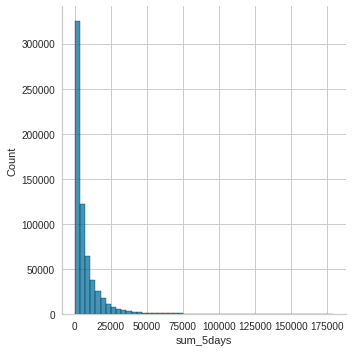

In [ ]:
# Plotting the sum_5days
sns.displot(debit_df['sum_5days'], bins= 50)

Majority of the accounts are debited with amounts ranging from 1 to 25000 within 5 days.

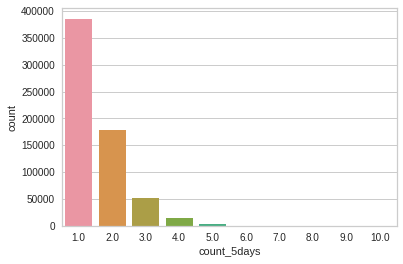

In [ ]:
# Plotting the count of 5 days transactions
sns.countplot(x= 'count_5days', data= debit_df)

Majority of the accounts have less than 4 transacctions within 5 days

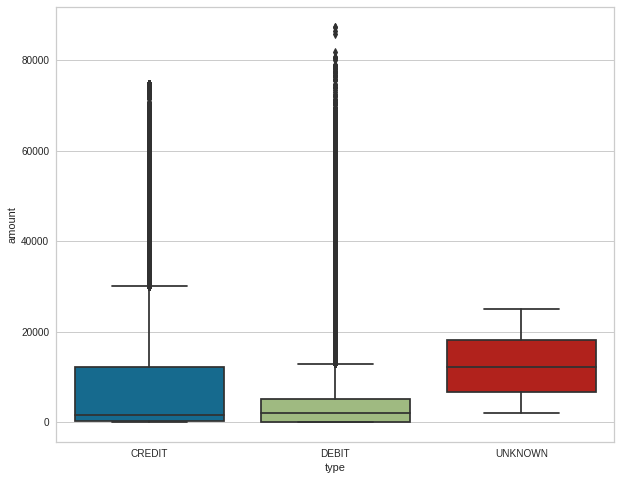

In [ ]:
# Creating a boxplot to check for outliers
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x= 'type', y= 'amount', data= trans)

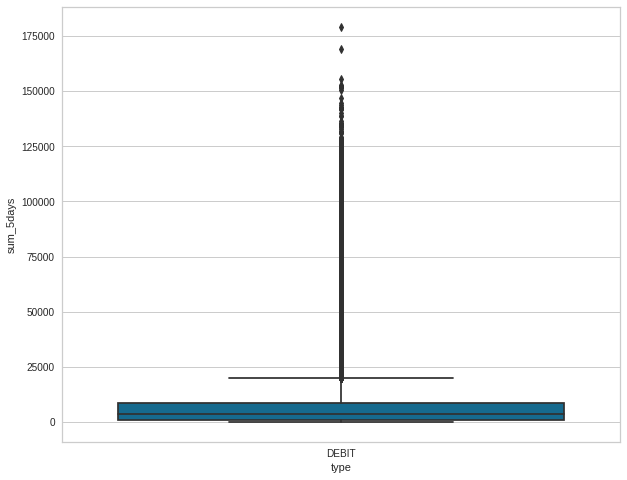

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x= 'type', y= 'sum_5days', data= debit_df)

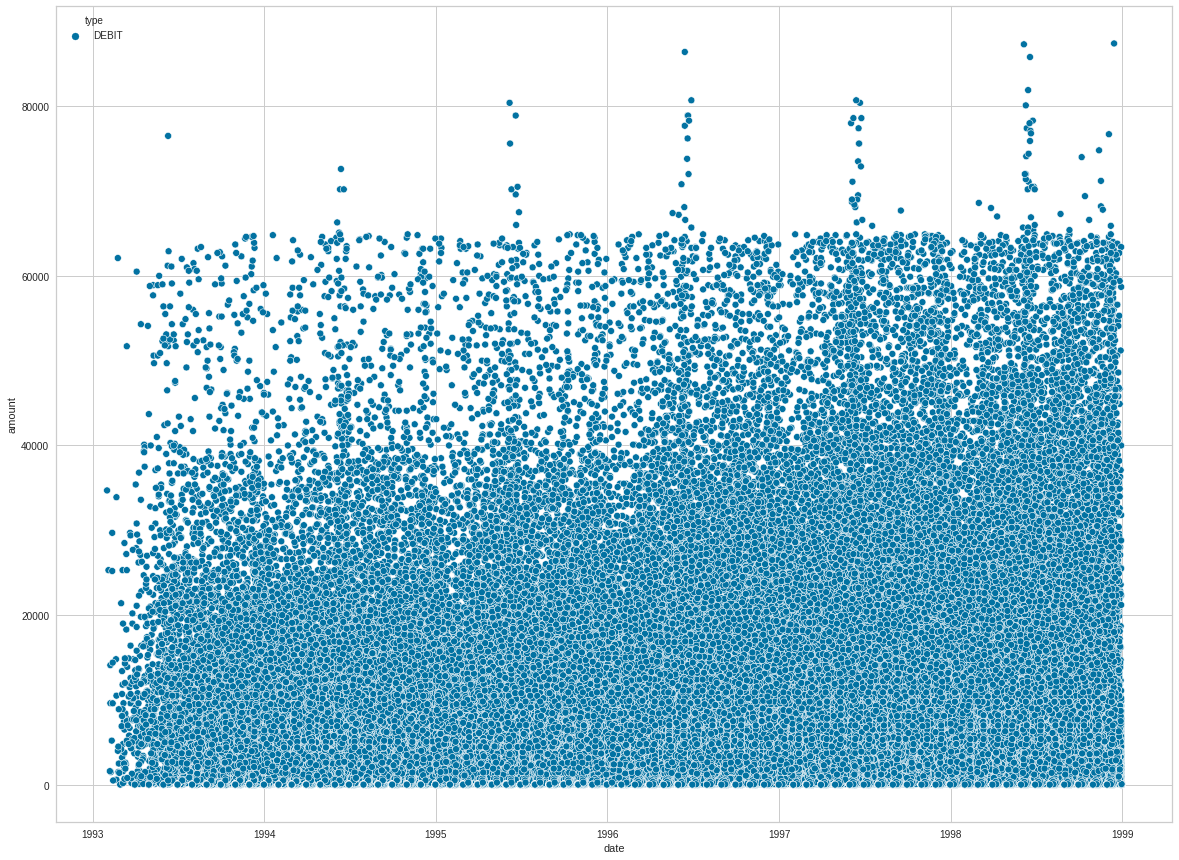

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.scatterplot(x= 'date', y= 'amount', hue= 'type', data= debit_df)

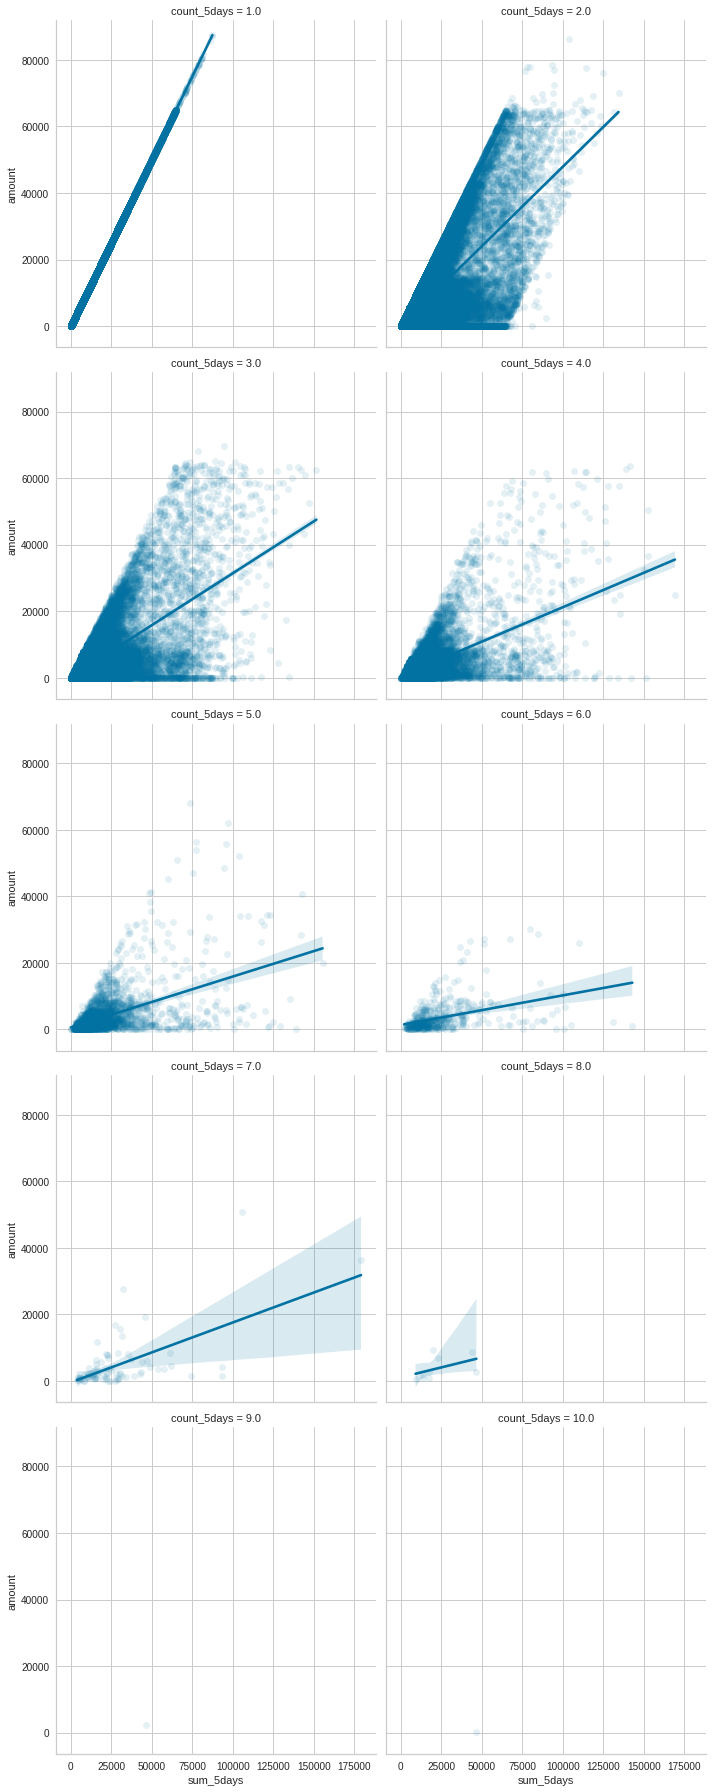

In [ ]:
# Create a scatter plot with linear regression line
# x-axis: sum_5days, y-axis: amount, data source: debit_df
# x_jitter: Add a small amount of noise to the x-axis to reduce overplotting
# scatter_kws: Additional keyword arguments to customize the appearance of the scatter points
# alpha: Transparency of the scatter points (set to 0.1)
# col: Variable used for faceting (breaks up the plot into multiple subplots based on count_5days)
# col_wrap: Number of columns in the grid of subplots (set to 2)

sns.lmplot(x='sum_5days', y='amount', data=debit_df, x_jitter=1, scatter_kws={'alpha':.1},
          col='count_5days', col_wrap=2)

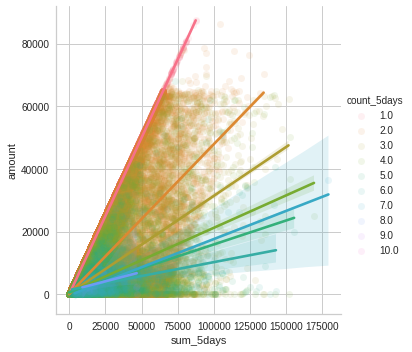

In [ ]:
# Create a scatter plot with linear regression line
# x-axis: sum_5days, y-axis: amount, data source: debit_df
# x_jitter: Add a small amount of noise to the x-axis to reduce overplotting
# scatter_kws: Additional keyword arguments to customize the appearance of the scatter points
# alpha: Transparency of the scatter points (set to 0.1)
# hue: Variable used for color encoding (color code points based on count_5days)

sns.lmplot(x='sum_5days', y='amount', data=debit_df, x_jitter=1, scatter_kws={'alpha':.1}, hue= 'count_5days')

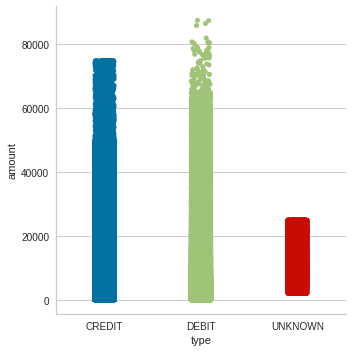

In [ ]:
sns.catplot(data=trans, x="type", y="amount")

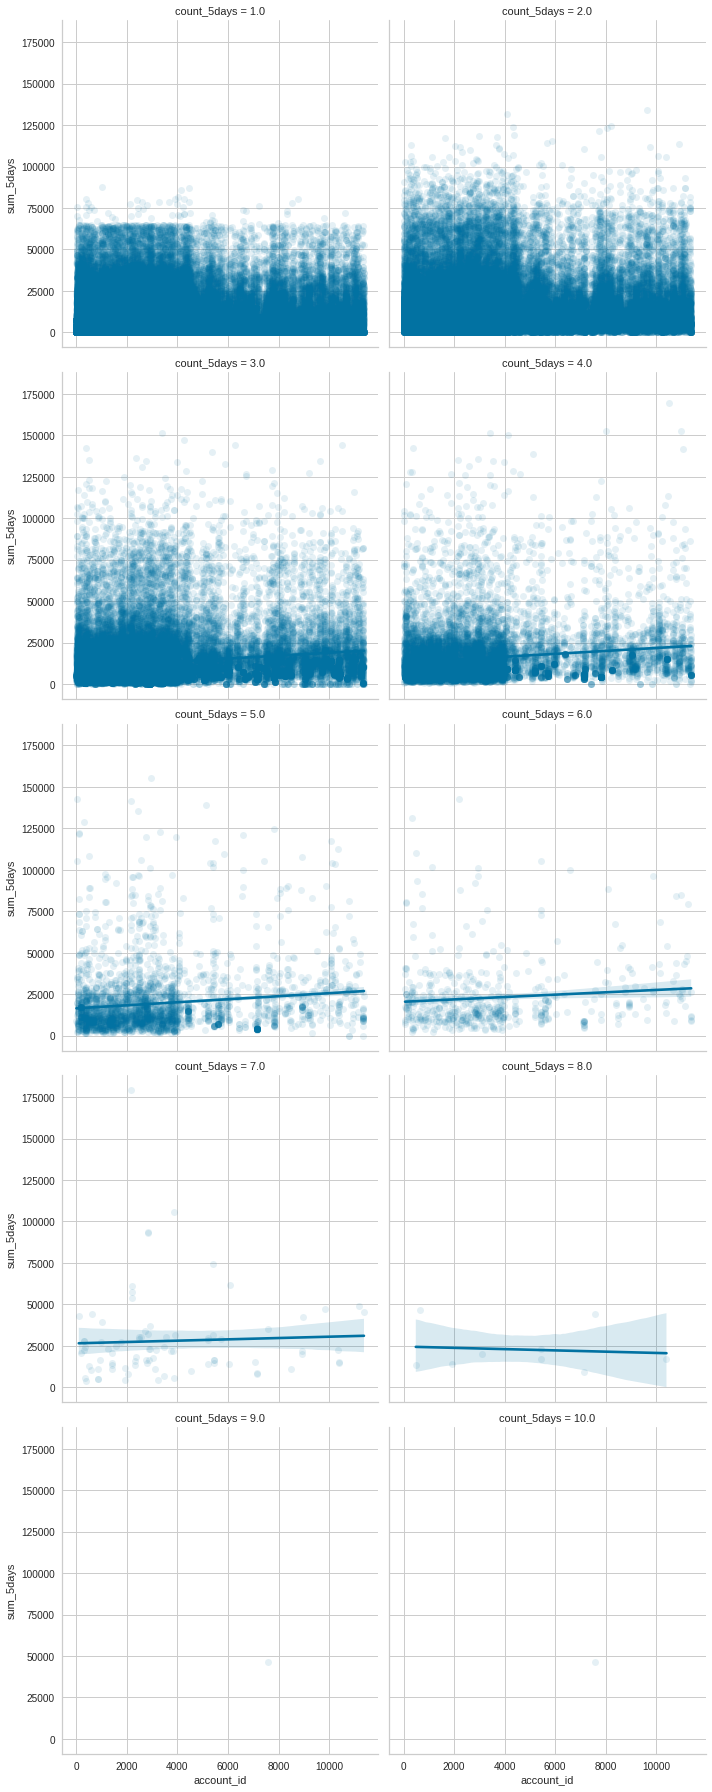

In [ ]:
sns.lmplot(x='account_id', y='sum_5days', data=debit_df, x_jitter=1, scatter_kws={'alpha':.1},
          col='count_5days', col_wrap=2)

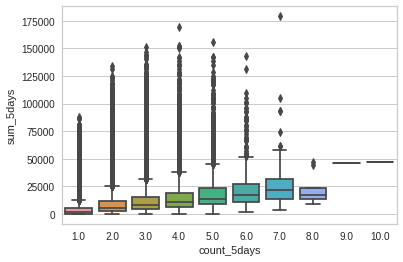

In [ ]:
sns.boxplot(x= 'count_5days', y= 'sum_5days', data= debit_df)

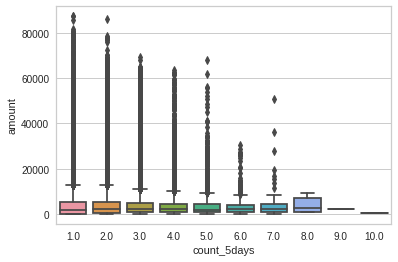

In [ ]:
sns.boxplot(x= 'count_5days', y= 'amount', data= debit_df)

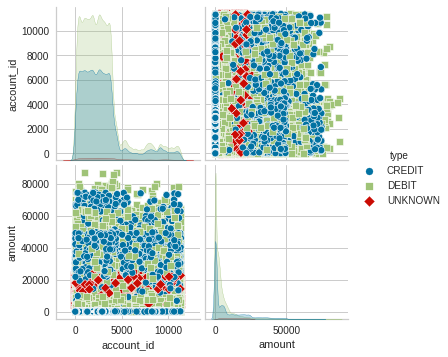

In [ ]:
# fig, ax = plt.subplots(figsize=(20, 20))
sns.pairplot(trans, hue="type", markers=["o", "s", "D"])

### Isolation Forest Model

Isolation Forest is an unsupervised learning algorithm that can effectively identify anomalies in the data. The algorithm works by building an ensemble of randomly generated decision trees and isolating anomalies in fewer partitions, which means they have fewer splits or levels in the decision tree. In other words, anomalies can be identified by their relatively short average path length in the decision tree.

Compared to other unsupervised learning algorithms, such as Local Outlier Factor (LOF) and One-Class SVM, Isolation Forest has several advantages. First, it can handle high-dimensional data and is not affected by the curse of dimensionality. Second, it requires less memory and computational resources, making it faster and more scalable. Third, it can also handle outliers that are close to normal instances, which may be challenging for other algorithms.

In [ ]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 KB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.0.7-py3-none-any.whl size=181101 sha256=9968b3cd9382b439acb296842831cf34016710a012eeae8a7c003c9515018b56
  Stored in directory: /root/.cache/pip/wheels/f7/e2/c1/1c7fd8b261e72411f6509afb429c84532e40ddcd96074473f4
Successfully built pyod


In [ ]:
# Importing Libraries
from pyod.models.iforest import IForest
from pyod.utils.data import generate_data

from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

anomaly_proportion = 0.001

# Training IForest indicator
clf_name = 'Anomaly detection - Isolation forest'
clf = IForest(contamination = anomaly_proportion)

X = debit_df[['count_5days', 'sum_5days']]
clf.fit(X)

debit_df['y_pred'] = clf.labels_ #binary labels (0=inlier, 1=outlier)
debit_df['y_scores'] = clf.decision_scores_ # raw outlier scores. The bigger the number the greater the anomaly.

In [ ]:
import numpy as np
import matplotlib

Text(0, 0.5, '5-day sum of withdrawal transactions')

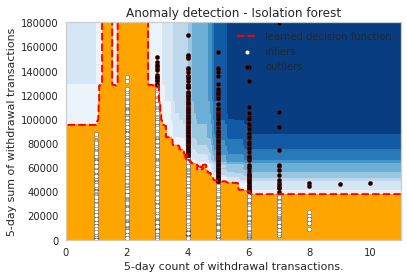

In [ ]:
xx , yy = np.meshgrid(np.linspace(0, 11, 200), np.linspace(0, 180000, 200))

# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])*-1
Z = Z.reshape(xx.shape)


threshold = (debit_df.loc[debit_df['y_pred'] == 1, 'y_scores'].min()*-1)/2 + (debit_df.loc[debit_df['y_pred'] == 0, 'y_scores'].max()*-1)/2


subplot = plt.subplot(1, 1, 1)

# fill blue colormap from minimum anomaly score to threshold value
subplot.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 10),cmap=plt.cm.Blues_r)

# draw red contour line where anomaly score is equal to threshold
a = subplot.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')

# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')

msk = debit_df['y_pred'] == 0
x = debit_df.loc[msk, ['count_5days', 'sum_5days']].values

# scatter plot of inliers with white dots
b = subplot.scatter(x[:, 0], x[:, 1], c='white',s=20, edgecolor='k') 


msk = debit_df['y_pred'] == 1
x = debit_df.loc[msk, ['count_5days', 'sum_5days']].values

# scatter plot of outliers with black dots
c = subplot.scatter(x[:, 0], x[:, 1], c='black',s=20, edgecolor='r')
subplot.axis('tight')



subplot.legend(
    [a.collections[0], b, c],
    ['learned decision function', 'inliers', 'outliers'],
    prop=matplotlib.font_manager.FontProperties(size=10),
    loc='upper right')
subplot.set_title(clf_name)
subplot.set_xlim((0, 11))
subplot.set_ylim((0, 180000))

subplot.set_xlabel("5-day count of withdrawal transactions.")
subplot.set_ylabel("5-day sum of withdrawal transactions")

In [ ]:
ranked_indices = debit_df['y_scores'].argsort()  # Indices of data points sorted by their anomaly scores
top_ranked_indices = ranked_indices[:10]  # Get the indices of the top 10 most anomalous data points

# Inspect the top 10 most anomalous data points
for i in top_ranked_indices:
    print(debit_df.iloc[i])

account_id         2662
type              DEBIT
amount             14.6
sum_5days          14.6
count_5days         1.0
y_pred                0
y_scores      -0.422239
Name: 1995-11-30 00:00:00, dtype: object
account_id         3143
type              DEBIT
amount             14.6
sum_5days          14.6
count_5days         1.0
y_pred                0
y_scores      -0.422239
Name: 1997-03-31 00:00:00, dtype: object
account_id          900
type              DEBIT
amount             14.6
sum_5days          14.6
count_5days         1.0
y_pred                0
y_scores      -0.422239
Name: 1994-11-30 00:00:00, dtype: object
account_id         3143
type              DEBIT
amount             14.6
sum_5days          14.6
count_5days         1.0
y_pred                0
y_scores      -0.422239
Name: 1997-04-30 00:00:00, dtype: object
account_id          900
type              DEBIT
amount             14.6
sum_5days          14.6
count_5days         1.0
y_pred                0
y_scores      -0.422

In [ ]:
ranked_indices = debit_df['y_scores'].argsort()[::-1]  # Indices of data points sorted by their anomaly scores in descending order
top_ranked_indices = ranked_indices[:10]  # Get the indices of the top 10 most anomalous data points

# Inspect the top 10 most anomalous data points
for i in top_ranked_indices:
    print(debit_df.iloc[i])

account_id         2176
type              DEBIT
amount          36300.0
sum_5days      179185.0
count_5days         7.0
y_pred                1
y_scores       0.046834
Name: 1993-08-05 00:00:00, dtype: object
account_id          319
type              DEBIT
amount           2196.0
sum_5days      131218.5
count_5days         6.0
y_pred                1
y_scores       0.046274
Name: 1998-09-14 00:00:00, dtype: object
account_id         2176
type              DEBIT
amount           1085.0
sum_5days      142885.0
count_5days         6.0
y_pred                1
y_scores       0.046274
Name: 1993-08-05 00:00:00, dtype: object
account_id         3869
type              DEBIT
amount          50700.0
sum_5days      105460.0
count_5days         7.0
y_pred                1
y_scores       0.045714
Name: 1996-01-08 00:00:00, dtype: object
account_id         5422
type              DEBIT
amount           1435.0
sum_5days      105287.0
count_5days         6.0
y_pred                1
y_scores       0.045

#### Output

In [ ]:
# Creating a dataframe containing transactions considered to be anomalies i.e. y_pred= 1
debit_df1 = debit_df.loc[debit_df['y_pred'] == 1]
debit_df1

,account_id,type,amount,sum_5days,count_5days,y_pred,y_scores
date,,,,,,,
1997-11-01,18,DEBIT,24700.0,101930.0,4.0,1,0.013335
1997-11-01,18,DEBIT,40600.0,142530.0,5.0,1,0.039023
1996-11-08,25,DEBIT,164.0,98474.0,4.0,1,0.012260
1996-11-10,25,DEBIT,6817.0,105291.0,5.0,1,0.037913
1996-12-10,25,DEBIT,6817.0,70991.0,4.0,1,0.001058
...,...,...,...,...,...,...,...
1998-01-04,11231,DEBIT,3900.0,48114.6,6.0,1,0.009043
1998-01-05,11244,DEBIT,1500.0,49200.0,5.0,1,0.000949
1998-01-07,11244,DEBIT,30300.0,79500.0,6.0,1,0.037913


In [ ]:
debit_df

,account_id,type,amount,sum_5days,count_5days,y_pred,y_scores
date,,,,,,,
1995-06-22,1,DEBIT,200.0,200.0,1.0,0,-0.341173
1995-07-22,1,DEBIT,5300.0,5300.0,1.0,0,-0.347591
1995-08-21,1,DEBIT,7500.0,7500.0,1.0,0,-0.325381
1995-08-31,1,DEBIT,14.6,14.6,1.0,0,-0.422239
1995-09-05,1,DEBIT,2452.0,2452.0,1.0,0,-0.362191
...,...,...,...,...,...,...,...
1998-10-31,11382,DEBIT,14.6,14.6,1.0,0,-0.422239
1998-11-02,11382,DEBIT,18900.0,18914.6,2.0,0,-0.262370
1998-11-30,11382,DEBIT,14.6,14.6,1.0,0,-0.422239


### Recommendations for Future Improvements

While the Isolation Forest algorithm and the engineered features have shown promising results, there are still opportunities for improvement. First, we recommend exploring other unsupervised learning techniques for anomaly detection, such as LOF or One-Class SVM, to compare their performance with Isolation Forest. Second, we suggest adding more features to capture long-term transaction patterns, which may further improve the accuracy of anomaly detection. Third, we encourage investigating the identified anomalies to confirm whether they are truly fraudulent or not, as there may be false positives or false negatives.

In conclusion, our project to detect anomalies in debit transactions using Isolation Forest and engineered features is a promising approach. Isolation Forest is an effective unsupervised learning algorithm for anomaly detection, and the engineered features can help to identify short-term patterns in the data. However, it's important to validate the results and investigate the identified anomalies to confirm whether they are truly fraudulent or not.